# The California Housing Dataset

---

### Colab Note

Don't forget that you can link your notebook to your drive and save your work there. Then you can download and backup your models, reload them to keep training them, or upload datasets to your drive. 

```python
import os
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('drive/My Drive/') # 'My Drive' is the default name of Google Drives
    os.listdir()
    
# use os.chdir("my-directory") # to change directory, and
# os.listdir()                 # to list its contents
# os.getcwd()                  # to get the name of the current directory
# os.mkdir("my-new-dir")       # to create a new directory
# See: https://realpython.com/working-with-files-in-python/

# You can also use bash commands directly, preceded by a bang
# !ls
# However, the following will *not* change the Python directory 
# the notebook points to (use os.chdir for that)!
# !cd my-directory
```

### For reproducible results

```python
tf.random.set_seed(42) # can be any number
```

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Method 2: Manual Download

[California Housing](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html), original website. (Also available on Kaggle: [California Housing, Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).)

### 1. Download

The terminal commands to download it. (Add a `!` in front of them to use them from Jupyter or Colab.)

```bash
wget https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz
tar -xvf cal_housing.tgz
```

In [ ]:
!wget https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz
tar -xvf cal_housing.tgz

### 2. Load the data

Use the name of the file `cal_housing.data` to:
- open it 
- read the lines 
- strip the final newline `\n` 
- split on commas
- turn the data into a numpy array, casting it as floats

**Note**

You can see the features by loading `cal_housing.domain`, read its lines, and print its contents

In [20]:
with open("CaliforniaHousing/cal_housing.data") as i:
    data = np.array([l.strip().split(",") for l in i.readlines()]).astype(float)

In [21]:
with open("CaliforniaHousing/cal_housing.domain") as i:
    categories = [l.split(": ")[0] for l in i.readlines()]

categories

['longitude',
 'latitude',
 'housingMedianAge',
 'totalRooms',
 'totalBedrooms',
 'population',
 'households',
 'medianIncome',
 'medianHouseValue']

### 3. Separate the features and the targets

The price is the last feature, so you need to use NumPy to slice all the `targets` in the last dimension, and the rest of the `features` in another array.

In [22]:
features, targets = data[:,:-1], data[:,-1].astype(float)

### 4. Split your data into train and test

Use `.shape` on your `features` (and/or `targets`) to check how many samples this dataset has.

Slice both `features` and `targets` to obtain `train_data`, `test_data`, and `train_targets`, `test_targets` respectively.

This is actually a potential subject of experiment. You could slice it roughly in the middle, or have more in your training than your testing set.

As a sanity check, your shapes should look like this:
```
# n_train: number of training samples
# n_train: number of testing samples
train_data (n_train, 8)
train_targets (n_train,)
test_data (n_test, 8)
test_targets (n_test,) 
```

In [23]:
train_data, test_data = features[:15000], features[15000:]
train_targets, test_targets = targets_small[:15000], targets_small[15000:]

In [24]:
print(train_data.shape)
print(train_targets.shape)
print(train_data.shape)
print(test_targets.shape)

(15000, 8)
(15000,)
(15000, 8)
(5640,)


In [25]:
train_targets

array([4.526, 3.585, 3.521, ..., 1.339, 1.339, 1.297])

### 6. Normalisation/scaling

Use the mean and standard deviation of the **train data** to normalise it, and apply the same transform to test data, exactly like with the Boston Housing Dataset.

Regarding the targets, you can print the `min()` and the `max()` to see the kind of range we are dealing with.

Depending which version, a division by `100000` will give you numbers between ~ `.1` and `5`.

Once you have your reduced targets, you may want to print again the `min()` and the `max()` as a sanity check.

In [28]:
# compute the mean, subtract from `train_data`
# then the std, and divide `train_data` by it
mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)
# shift & rescale
x_train = (train_data - mean) / std 

# create an `x_test from `test_data`  using `mean` and `std` computed above
x_test = (test_data - mean) / std

# rescale only if necessary
y_train = train_targets # / 100_000
y_test = test_targets # / 100_000

In [29]:
print("train targets max:", train_targets.max(), "train targets min:", train_targets.min())
print("y train max:", y_train.max(), "y train min:", y_train.min())

train targets max: 5.00001 train targets min: 0.14999
y train max: 5.00001 y train min: 0.14999


### 7. Everything is now set up for training

The rest of the procedure (define the model, train, plot) is now the same.

In [30]:
def build_model(clear=True):
    if clear:
        tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input((x_train.shape[1],)))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        optimizer='rmsprop',
        loss='mse',
        metrics=['mae']
    )
    return model

In [31]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):
        c = ['|', '/', '-', '\\'] 
        print(f"\r{c[epoch % 4]} epoch: {epoch+1}/{self.epochs}", end="")
    def on_train_end(self, logs=None):
        print()

In [32]:
K = 4
num_val_samples = len(x_train) // K
num_epochs = 50
all_mae_histories = []
for i in range(K):
    print('processing fold', i)
    
    # Prepare the validation data: data from partition i
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    val_data = x_train[a : b]
    val_targets = y_train[a : b]
    
    # Prepare the training data: data from all other partitions
    partial_x_train = np.concatenate([x_train[:a], x_train[b:]], axis=0)
    partial_y_train = np.concatenate([y_train[:a], y_train[b:]], axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(
        partial_x_train,
        partial_y_train,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=128, verbose=0, 
        callbacks=[CustomCallback(num_epochs)]
    )

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold 0
| epoch: 1/50

I0000 00:00:1764862391.331011 10388576 service.cc:148] XLA service 0x6000016dc300 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764862391.331034 10388576 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1764862391.610751 10438021 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


/ epoch: 50/50
processing fold 1
/ epoch: 50/50
processing fold 2
/ epoch: 50/50
processing fold 3
/ epoch: 50/50


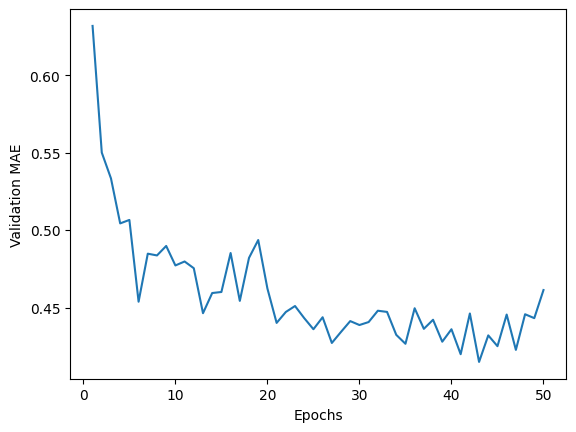

In [33]:
average_mae_history = np.array(all_mae_histories).mean(axis=0)
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [34]:
def smooth_curve(points, beta = 0.9):       # beta must be between 0 and 1!
    smoothed_points = []
    for current in points:
        if smoothed_points:                 # (an nonempty list is 'True')
            previous = smoothed_points[-1]  # the last appended point
                                            # ↓ a weighted sum of previous & point, controlled by beta
            smoothed_points.append(beta * previous + (1 - beta) * current)
        else:
            smoothed_points.append(current) # at the start, the list is empty, we just add the first point
    return smoothed_points

In [36]:
np.min(average_mae_history).item() * 100000

41489.654779434204

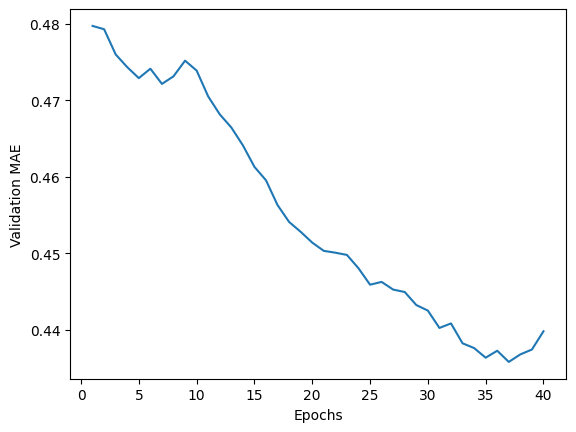

In [37]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
(train_data, train_targets), (test_data, test_targets) = keras.datasets.california_housing.load_data(version="small")
print(train_data.shape, test_data.shape)

In [ ]:
print(test_targets.max())
print(test_targets.min())

### Normalization

Compute `mean` and `std` from `train_data`, and apply those to both `train_data` and `test_data`.

In [ ]:
# compute the mean, and std from `train_data`
# create an `x_train` that is normalised using those statistics

# create an `x_test from `test_data`  using `mean` and `std` computed above

# create `y_train` and `y_test` by dividing 
# `train_targets` and `test_targets` by 100_000


### Model building & callback

In [ ]:
def build_model(clear=True):
    if clear:
        tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input((x_train.shape[1],)))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        optimizer='rmsprop',
        loss='mse',
        metrics=['mae']
    )
    return model

##### Note

Can you make the function above more modular? You could modify it so that it accepts arguments changing the architecture of the network, and other hyperparameters.

#### Custom Callback

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):
        c = ['|', '/', '-', '\\']
        print(f"\r{c[epoch % 4]} epoch: {epoch+1}/{self.epochs}", end="")
    def on_train_end(self, logs=None):
        print()

### The K-fold algorithm

In [ ]:
K = 4
num_val_samples = len(x_train) // K
num_epochs = 100
all_mae_histories = []

for i in range(K):
    print('processing fold', i)
    
    # Prepare the validation data: data from partition i
    a, b =        # prepare indices
    val_data =    # extract validation samples from x_train
    val_targets = # extract validation targets from train_targets
    
    # Prepare the training data: data from all other partitions
    partial_x_train =    # extract partial train samples from x_train
    partial_train_targets = # # extract partial train samples from  train_targets

    # Build the Keras model (already compiled)
    model = # use your function
    
    # Train the model using .fit()
    # - train: partial_x_train, partial_train_targets
    # - validation: val_data, val_targets
    # - number of epochs, batch_size=1 for now
    # - silent mode recommended, verbose=0
    # collect the returned object in `history`

    mae_history = # collect val_mae from history
    # add mae_history to all_mae_histories

### Visualise your results

Can you think of a way to automate the visualisation once the training is done? This would mean encapsulating the plotting code into a function, and calling it once the K-fold loop is done.

In [ ]:
average_mae_history = np.array(all_mae_histories).mean(axis=0)
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
def smooth_curve(points, beta = 0.9):       # beta must be between 0 and 1!
    smoothed_points = []
    for current in points:
        if smoothed_points:                 # (an nonempty list is 'True')
            previous = smoothed_points[-1]  # the last appended point
                                            # ↓ a weighted sum of previous & point, controlled by beta
            smoothed_points.append(beta * previous + (1 - beta) * current)
        else:
            smoothed_points.append(current) # at the start, the list is empty, we just add the first point
    return smoothed_points

In [ ]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Experiments

- Run k-fold validation on the California dataset;
- Notice that the mini-batch size is set to 1. Experiment with different mini-batch sizes. What do you observe? Can you account for your observation?
- Run a series of experiments to find the best model, like in previous labs.
- A more advanced experiment could be to implement *iterated K-fold validation with shuffling*, as mentioned in the lecture.

The obvious thing to be done here is to compare the results between the small random subset and the full dataset, if you were to train models on it (don't forget to split into train, validation and test sets when you work on the full data!). Varying the size of the test set could also be of interest.

### 2. Conclusion

Retrain the best model:
 - with the same hyperparameters
 - on the entire the training data (`train_data` and `train_targets`)
 - without validation data
 - up until the best epoch (lowest average MAE)
 - and then evaluate on the test data (`test_data`, `test_targets`).

You can now use your model to make predictions by selecting one data point in `x_test`, and compare the prediction to the equivalent price in `y_test`.

---

[California Housing](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html), original website. (Also available on [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).)

### 1. Download

The terminal commands to download it. (Add a `!` in front of them to use them from Jupyter or Colab.)

```bash
wget https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz
tar -xvf cal_housing.tgz
```

### 2. Load the data

Use the name of the file `cal_housing.data` to:
- open it 
- read the lines 
- strip the final newline `\n` 
- split on commas
- turn the data into a numpy array, casting it as floats

**Note**

You can see the features by loading `cal_housing.domain`, read its lines, and print its contents

### 3. Separate the features and the targets

The price is the last feature, so you need to use NumPy to slice all the `targets` in the last dimension, and the rest of the `features` in another array.

### 4. Scale the prices to a more manageable range

You can print the `min()` and the `max()` of your `targets` to see the kind of range we are dealing with.

Then a division by `100000` will give us similar numbers to the Boston Housing Dataset (and the `scikit-learn` version, as above).

Once you have your reduced targets, you may want to print again the `min()` and the `max()` as a sanity check.

### 5. Reduce the dataset to Boston Housing size, or split your data into train and test

Use `.shape` on your `features` (and/or `targets`) to check how many samples this dataset has.

Either use random indices as above to select only 504 samples, or train normally, but splitting into train and test sets.

Slice both `features` and `targets` to obtain `train_data`, `test_data`, and `train_targets`, `test_targets` respectively.

This is actually a potential subject of experiment. You could slice it roughly in the middle, or have more in your training than your testing set.

As a sanity check, your shapes should look like this:
```
# n_train: number of training samples
# n_train: number of testing samples
train_data (n_train, 8)
train_targets (n_train,)
test_data (n_test, 8)
test_targets (n_test,)
```

### 6. Normalisation/scaling

Use the mean and standard deviation of the **train data** to normalise it, and apply the same transform to test data, exactly as above with the Boston Housing Dataset.

### 7. Everything is now set up for training

The rest of the procedure (define the model, train, plot) is now the same.

### Experiments

The obvious thing to be done here is to compare the results between the small random subset and the full dataset. Varying the size of the test set could also be of interesting!

### 8. Conclusion

Retrain the best model (with the same hyperparameters on the entire the training data (`train_data` and `train_targets`) **without validation data** and instead evaluate on the test data (`test_data`, `test_targets`).

### Visualisations

Three examples of how people use visualisations for this dataset:
- [California Housing Modelling and Map Visualisation](https://www.kaggle.com/code/qixuan/california-housing-modelling-and-map-visualisation)
- [California Housing Prices: EDA and Visualization](https://www.kaggle.com/code/ujwalkandi/california-housing-prices-eda-and-visualization)
- [The California housing dataset](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html)